In [1]:
import os, json, random, cv2
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf, re, math
from tqdm import tqdm

In [2]:
%%time

### Create Kaggle Dataset if not exists 

DATASET_NAME = f'happywhale-tfrecords-v1'

!rm -r /tmp/{DATASET_NAME}

os.makedirs(f'/tmp/{DATASET_NAME}', exist_ok=True)

with open('../input/kaggle-api-creds/kaggle.json') as f:
    kaggle_creds = json.load(f)
    
os.environ['KAGGLE_USERNAME'] = kaggle_creds['username']
os.environ['KAGGLE_KEY'] = kaggle_creds['key']

!kaggle datasets init -p /tmp/{DATASET_NAME}


with open(f'/tmp/{DATASET_NAME}/dataset-metadata.json') as f:
    dataset_meta = json.load(f)
dataset_meta['id'] = f'ks2019/{DATASET_NAME}'
dataset_meta['title'] = DATASET_NAME
with open(f'/tmp/{DATASET_NAME}/dataset-metadata.json', "w") as outfile:
    json.dump(dataset_meta, outfile)
print(dataset_meta)

!cp /tmp/{DATASET_NAME}/dataset-metadata.json /tmp/{DATASET_NAME}/meta.json
!ls /tmp/{DATASET_NAME}

!kaggle datasets create -u -p /tmp/{DATASET_NAME} 

rm: cannot remove '/tmp/happywhale-tfrecords-v1': No such file or directory
Data package template written to: /tmp/happywhale-tfrecords-v1/dataset-metadata.json
{'title': 'happywhale-tfrecords-v1', 'id': 'ks2019/happywhale-tfrecords-v1', 'licenses': [{'name': 'CC0-1.0'}]}
dataset-metadata.json  meta.json
Starting upload for file meta.json
100%|███████████████████████████████████████████| 111/111 [00:05<00:00, 19.0B/s]
Upload successful: meta.json (111B)
Dataset creation error: The requested title "happywhale-tfrecords-v1" is already in use by a dataset. Please choose another title.
CPU times: user 223 ms, sys: 80.9 ms, total: 304 ms
Wall time: 12.5 s


In [3]:
train_df = pd.read_csv('../input/happywhale-splits/skf_species_10folds.csv')
test_df = pd.read_csv('../input/happy-whale-and-dolphin/sample_submission.csv')
test_df['split'] = test_df.index%10
train_df.agg(['min','max','count','nunique'])

,image,species,individual_id,fold
min,00021adfb725ed.jpg,0,0,0.0
max,fffdcd42312777.jpg,29,15586,9.0
count,51033,51033,51033,51033.0
nunique,51033,30,15587,10.0


In [4]:
def get_fold(fold):
    val_df = train_df[train_df.fold==fold].reset_index(drop=True)
    val_df['order'] = val_df.index
    val_df['order'] = val_df.groupby('individual_id').order.rank()
    val_total_counts = val_df.individual_id.value_counts().to_dict()
    val_df['total_counts'] = val_df.individual_id.map(val_total_counts)
    val_df['order'] = val_df['order']/val_df['total_counts']
    val_df = val_df.sort_values('order',ascending=False).reset_index(drop=True)
    val_df = val_df[['image','species','individual_id']]
    return val_df

In [5]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(image,image_name,target,species):
    feature = {
        'image': _bytes_feature(image),
        'image_name': _bytes_feature(image_name),
        'target': _int64_feature(target),
        'species': _int64_feature(species),
      }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [6]:
def create_tf_records(fold  = 0):
    df = get_fold(fold)
    tfr_filename = f'/tmp/{DATASET_NAME}/happywhale-2022-train-{fold}-{df.shape[0]}.tfrec'
    with tf.io.TFRecordWriter(tfr_filename) as writer:
        for i,row in df.iterrows():
            image_id = row.image
            target = row.individual_id
            species = row.species
            image_path = f"../input/happy-whale-and-dolphin/train_images/{image_id}"
            image_encoded = tf.io.read_file(image_path)
            image_name = str.encode(image_id)
            example = serialize_example(image_encoded,image_name,target,species)
            writer.write(example)

In [7]:
import joblib
_ = joblib.Parallel(n_jobs=8)(
        joblib.delayed(create_tf_records)(fold) for fold in tqdm(range(10))
    )

100%|██████████| 10/10 [00:00<00:00, 38.77it/s]
2022-02-05 07:38:19.793747: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-02-05 07:38:19.946580: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-02-05 07:38:20.052704: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-02-05 07:38:20.250096: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.
2022-02-05 07:38:20.419106: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4.

In [8]:
def create_test_tf_records(fold  = 0):
    df = test_df[test_df.split==fold]
    tfr_filename = f'/tmp/{DATASET_NAME}/happywhale-2022-test-{fold}-{df.shape[0]}.tfrec'
    with tf.io.TFRecordWriter(tfr_filename) as writer:
        for i,row in df.iterrows():
            image_id = row.image
            target = -1
            species = -1
            image_path = f"../input/happy-whale-and-dolphin/test_images/{image_id}"
            image_encoded = tf.io.read_file(image_path)
            image_name = str.encode(image_id)
            example = serialize_example(image_encoded,image_name,target,species)
            writer.write(example)

In [9]:
import joblib
_ = joblib.Parallel(n_jobs=8)(
        joblib.delayed(create_test_tf_records)(fold) for fold in tqdm(range(10))
    )

100%|██████████| 10/10 [00:00<00:00, 539.61it/s]


In [10]:
from datetime import datetime
version_name = datetime.now().strftime("%Y%m%d-%H%M%S")
print(version_name)

20220205-075102


In [11]:
!ls /tmp/{DATASET_NAME}

dataset-metadata.json		   happywhale-2022-train-0-5104.tfrec
happywhale-2022-test-0-2796.tfrec  happywhale-2022-train-1-5104.tfrec
happywhale-2022-test-1-2796.tfrec  happywhale-2022-train-2-5104.tfrec
happywhale-2022-test-2-2796.tfrec  happywhale-2022-train-3-5103.tfrec
happywhale-2022-test-3-2796.tfrec  happywhale-2022-train-4-5103.tfrec
happywhale-2022-test-4-2796.tfrec  happywhale-2022-train-5-5103.tfrec
happywhale-2022-test-5-2796.tfrec  happywhale-2022-train-6-5103.tfrec
happywhale-2022-test-6-2795.tfrec  happywhale-2022-train-7-5103.tfrec
happywhale-2022-test-7-2795.tfrec  happywhale-2022-train-8-5103.tfrec
happywhale-2022-test-8-2795.tfrec  happywhale-2022-train-9-5103.tfrec
happywhale-2022-test-9-2795.tfrec  meta.json


In [12]:
!kaggle datasets version -m {version_name} -p /tmp/{DATASET_NAME} -r zip -q

Dataset version is being created. Please check progress at https://www.kaggle.com/ks2019/happywhale-tfrecords-v1


## Verify TFRecords

In [13]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.image.resize(image,IMAGE_SIZE_)
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        'target': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = example['target']
    return image, label # returns a dataset of (image, label) pairs

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    #    numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def display_single_sample(image, label, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    title = str(label)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch):
    """
    Display single batch Of images 
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        correct = True
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_single_sample(image, label, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [15]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

10



User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KM

51033


2022-02-05 08:34:06.377976: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-05 08:34:16.395309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 561 of 2048
2022-02-05 08:34:26.435166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1129 of 2048
2022-02-05 08:34:36.383745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1663 of 2048
2022-02-05 08:34:43.622784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


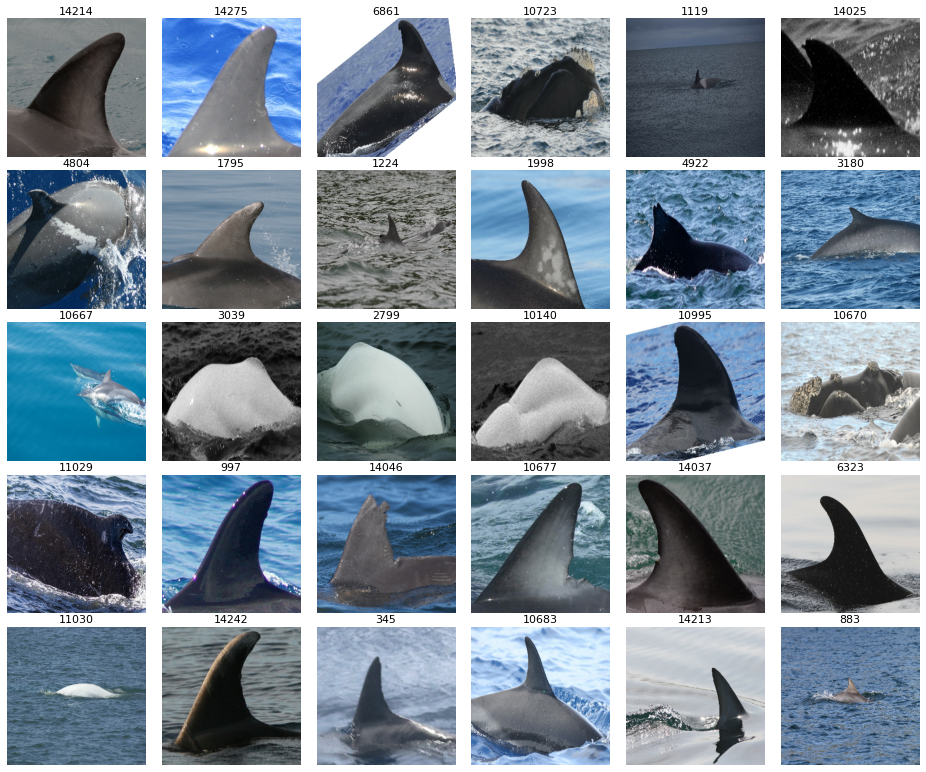

In [16]:
IMAGE_SIZE_ = [IMAGE_SIZE,IMAGE_SIZE]
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob(f'/tmp/{DATASET_NAME}/happywhale-2022-train*.tfrec')
print(len(TRAINING_FILENAMES))
dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
dataset = dataset.repeat()
dataset = dataset.shuffle(2048)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(AUTO) #This dataset can directly be passed to keras.fit method
print(count_data_items(TRAINING_FILENAMES))

# Displaying single batch of TFRecord
train_batch = iter(dataset)
display_batch_of_images(next(train_batch))

10
27956


2022-02-05 08:34:57.330469: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 469 of 2048
2022-02-05 08:35:07.370454: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 961 of 2048
2022-02-05 08:35:17.435812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1427 of 2048
2022-02-05 08:35:27.441132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1915 of 2048
2022-02-05 08:35:30.359352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


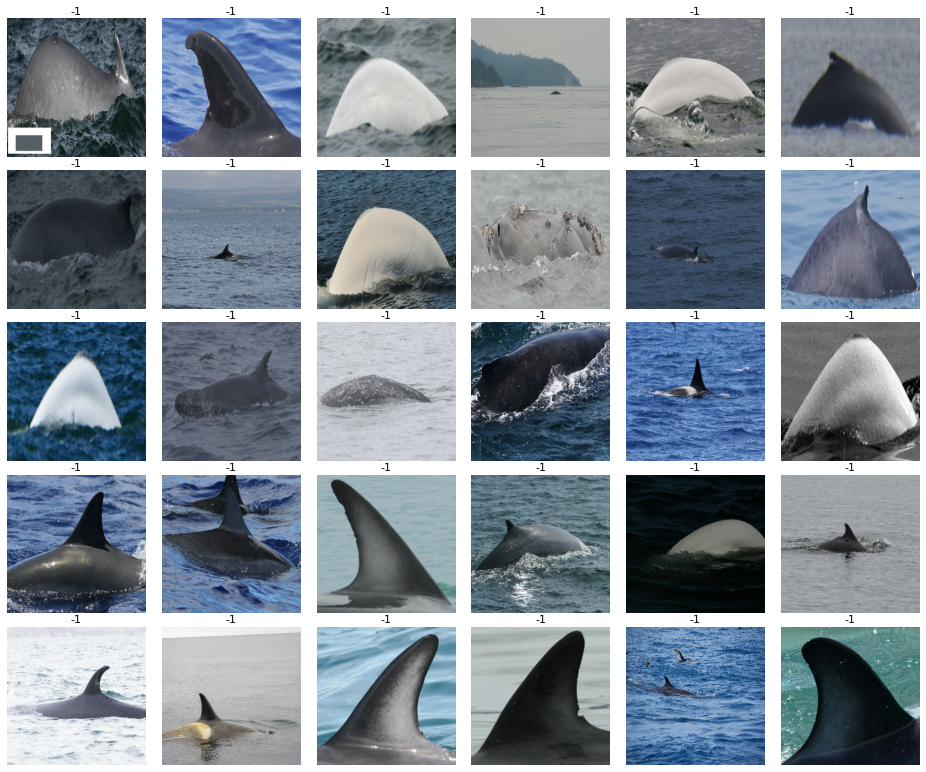

In [17]:
IMAGE_SIZE_ = [IMAGE_SIZE,IMAGE_SIZE]
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob(f'/tmp/{DATASET_NAME}/happywhale-2022-test*.tfrec')
print(len(TRAINING_FILENAMES))
dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
dataset = dataset.repeat()
dataset = dataset.shuffle(2048)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(AUTO) #This dataset can directly be passed to keras.fit method
print(count_data_items(TRAINING_FILENAMES))

# Displaying single batch of TFRecord
train_batch = iter(dataset)
display_batch_of_images(next(train_batch))